**This notebook represents a classification problem to predict whether a patient is infected with covid-19 or not using the following dataset:** https://www.kaggle.com/datasets/einsteindata4u/covid19

In [266]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, learning_curve, RandomizedSearchCV
from warnings import filterwarnings
filterwarnings('ignore')

In [13]:
#load dataset
df = pd.read_excel(r'C:\Users\rootmerouane\Downloads\datasets\dataset.xlsx')
pd.set_option('display.max_columns',111)
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

**EXPLORATORY DATA ANALYSIS**

In [30]:
display(df.shape)


(5644, 38)

In [12]:
# variable types
pd.set_option('display.max_row',111)
df.dtypes.value_counts()

float64    70
object     37
int64       4
dtype: int64

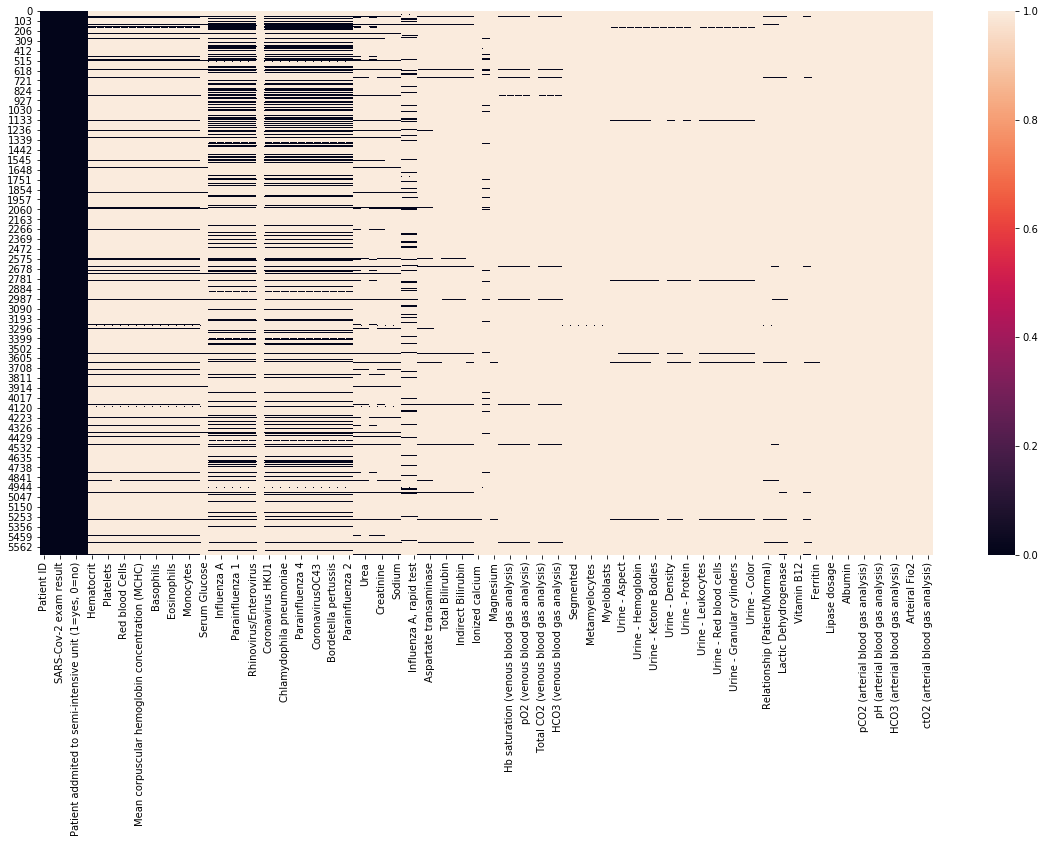

In [16]:
# Visualize the NA 
plt.figure(figsize=(20,10)) 
sns.heatmap(df.isna())

**- The dataset contains a lot of NA values especially the features to the right**

**- There seems to be  a group pattern between the features in terms of the NA values count, which is confirmed by the results below**

In [19]:
(df.isna().sum()/df.shape[0]).sort_values(ascending = True)

Patient ID                                               0.000000
Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Influenza B                                              0.760099
Respiratory Syncytial Virus                              0.760099
Influenza A                                              0.760099
Rhinovirus/Enterovirus                                   0.760454
Inf A H1N1 2009                                          0.760454
CoronavirusOC43                                          0.760454
Coronavirus229E                                          0.760454
Parainfluenza 4                                          0.760454
Adenovirus                                               0.760454
Chlamydoph

In [27]:
# clean the dataset
df = df[df.columns [df.isna().sum()/df.shape[0] < 0.9]]
df = df.drop('Patient ID', axis =1)

In [32]:
#target variable
df['SARS-Cov-2 exam result'].value_counts(normalize = True)

negative    0.901134
positive    0.098866
Name: SARS-Cov-2 exam result, dtype: float64

**Our target classes are not balanced**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000171E0DA0>,
      dtype=object)

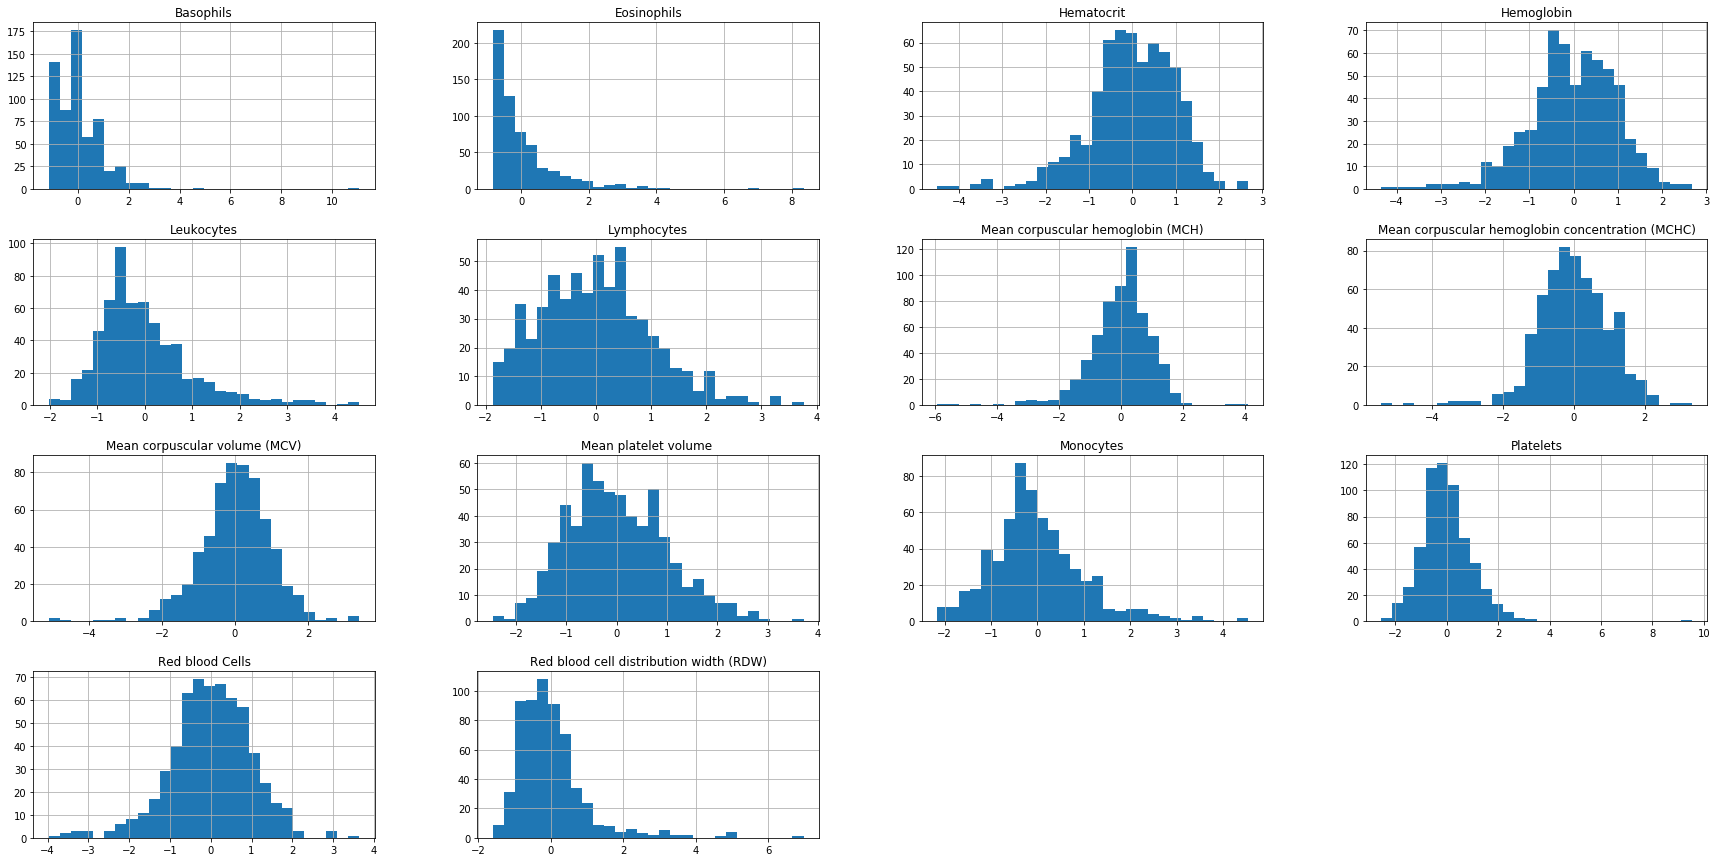

In [37]:
# features distrbution
K = int(1 + 3.22 * np.log(df.shape[0]))
df.select_dtypes('float').hist(bins=K,figsize=(30,15))

**Notice that some features are  around zero (already standard values), some skewed**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000187C90B8>,
      dtype=object)

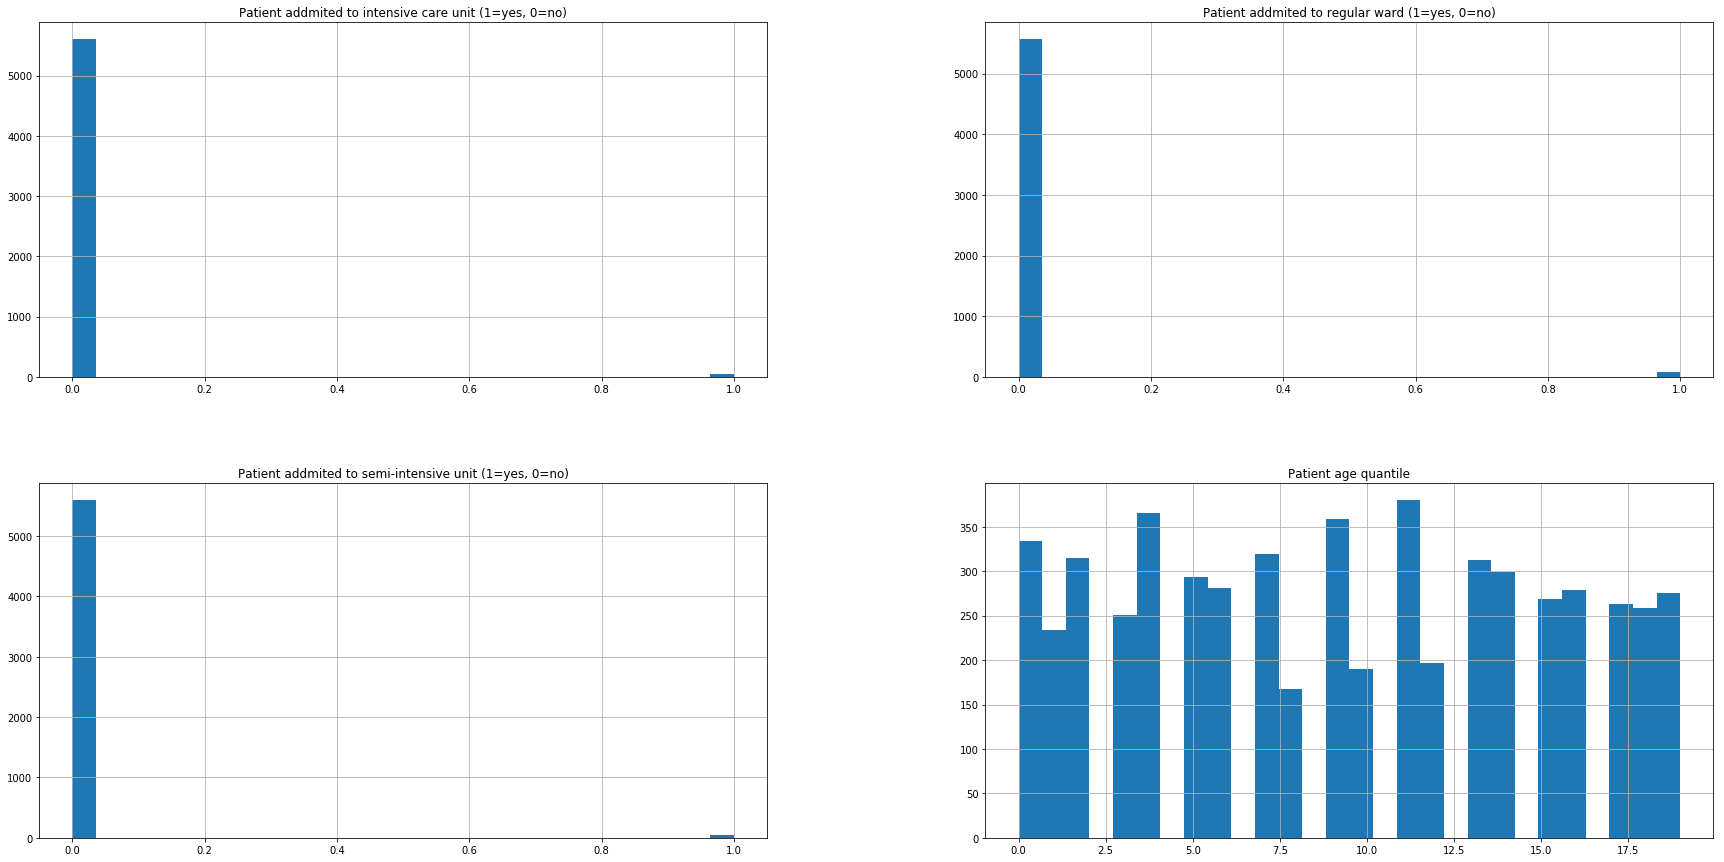

In [41]:
df.select_dtypes('int64').hist(bins=K,figsize=(30,15))

In [50]:
for col in df.select_dtypes('object'):
    print(col, df[col].unique())


(u'SARS-Cov-2 exam result', array([u'negative', u'positive'], dtype=object))
(u'Respiratory Syncytial Virus', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Influenza A', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Influenza B', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Parainfluenza 1', array([nan, u'not_detected', u'detected'], dtype=object))
(u'CoronavirusNL63', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Rhinovirus/Enterovirus', array([nan, u'detected', u'not_detected'], dtype=object))
(u'Coronavirus HKU1', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Parainfluenza 3', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Chlamydophila pneumoniae', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Adenovirus', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Parainfluenza 4', array([nan, u'not_detected', u'detected'], dtype=object))
(u'Coronavirus229E', array([nan, u'not

In [58]:
df['Parainfluenza 2'].value_counts(normalize = 'True')

not_detected    1.0
Name: Parainfluenza 2, dtype: float64

**The feature 'Parainfluenza 2' has only one category**

ValueError: num must be 1 <= num <= 10, not 11

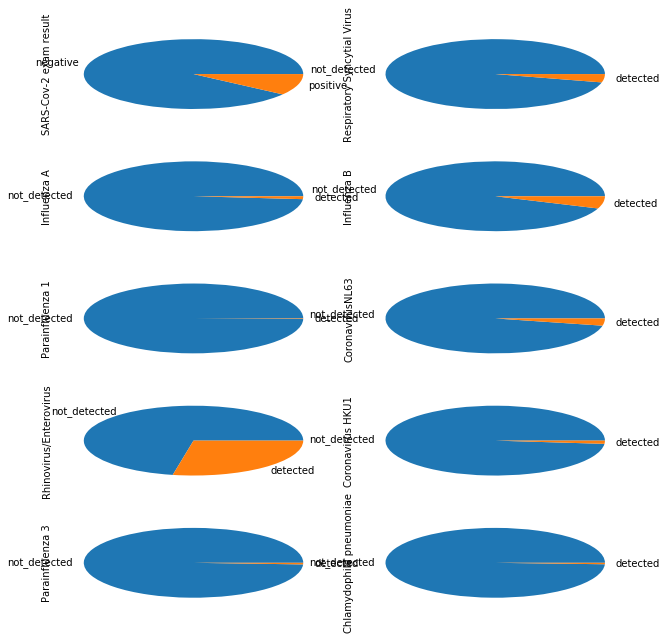

In [55]:
plt.figure(figsize=(10,10))
for i,col in enumerate(df.select_dtypes('object')):
    plt.subplot(5,2,i+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
    df[col].value_counts().plot.pie()
    
    

**Notice that only one feature 'Rhinovirus/Enterovirus' has a high "detected" percentage compared to the others**

In [62]:
# target vs continuous features
pos_df = df[df['SARS-Cov-2 exam result'] == 'positive']
neg_df = df[df['SARS-Cov-2 exam result'] == 'negative']

As discussed earlier, we use the NA value counts to group the features into two sub-groups

In [66]:
NA_count = df.isna().sum()/df.shape[0]

In [105]:
grp1 = df.columns[(NA_count >0.88)&(NA_count <0.9)] 
grp2 = df.columns[(NA_count >0.75)&(NA_count <0.88)] 

In [ ]:
# let's visualize continuous features vs target 
# then categorical features vs target 

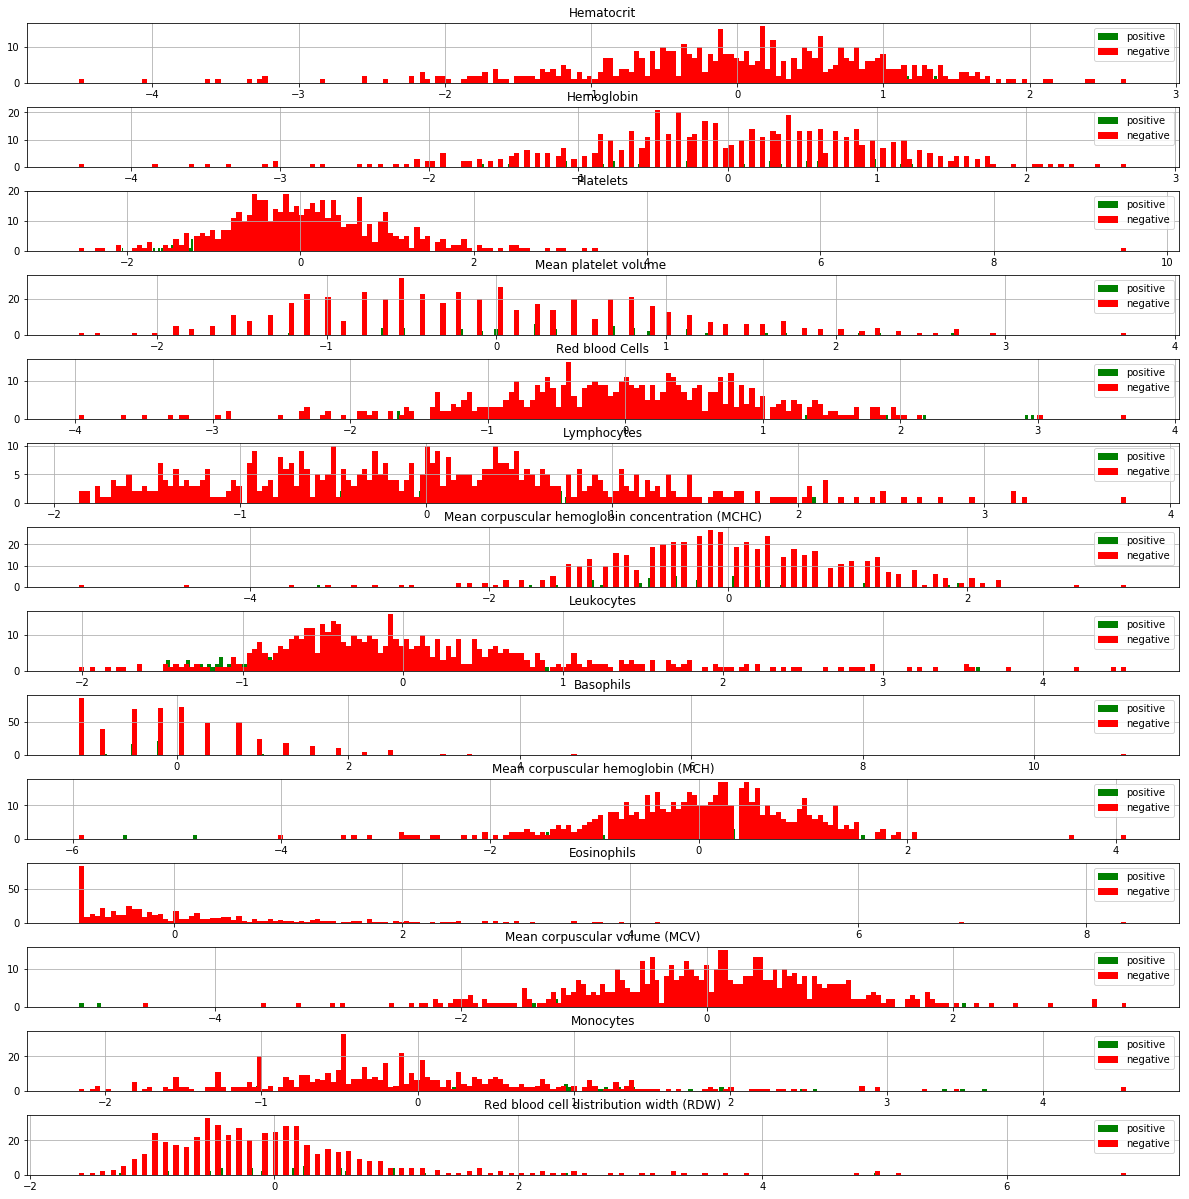

In [112]:
plt.figure(figsize = (20,20))
i = 0
for col in grp1:
    plt.subplot(14,1,i+1)
    i = i+1
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)
    pos_df[col].hist(color='g', bins=200, label='positive')
    neg_df[col].hist(color='r', bins=200, label='negative')
  
    plt.legend()
    plt.title(col)

**When zooming in on 'monocytes', 'platelets' and 'leukocytes', we can see a difference of their distrbutions of positive and negative cases as opposed to other continuous features.**

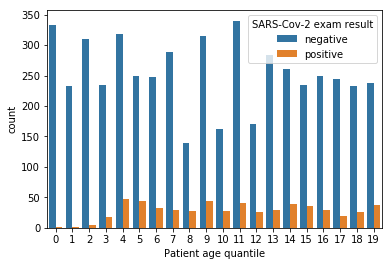

In [96]:
sns.countplot(x = 'Patient age quantile', hue = 'SARS-Cov-2 exam result', data = df)

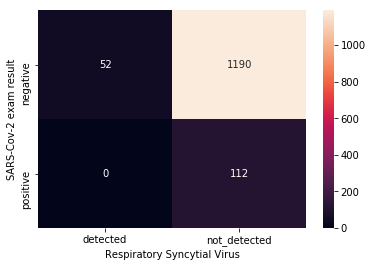

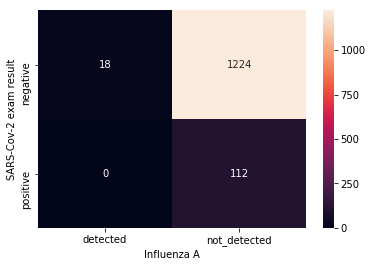

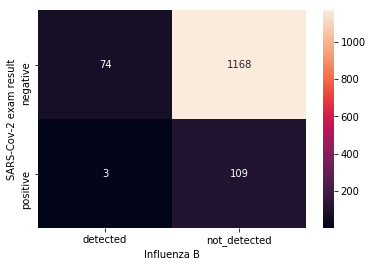

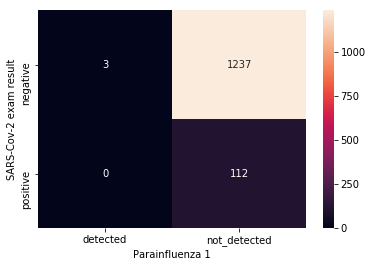

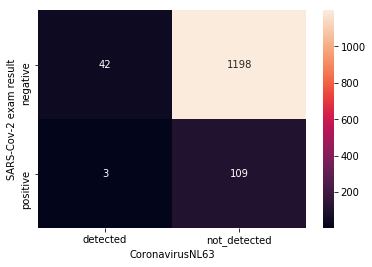

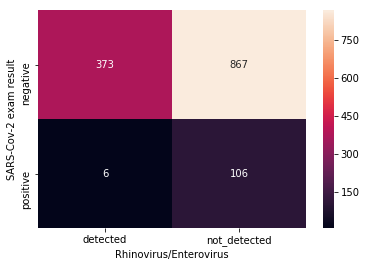

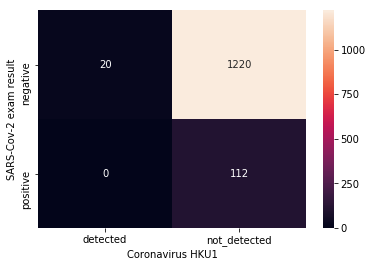

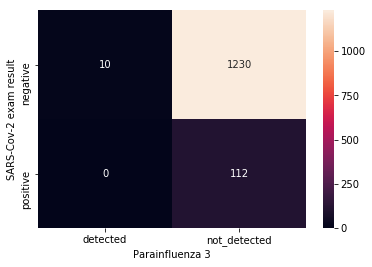

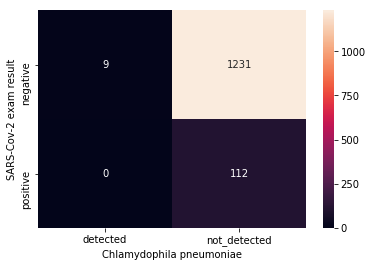

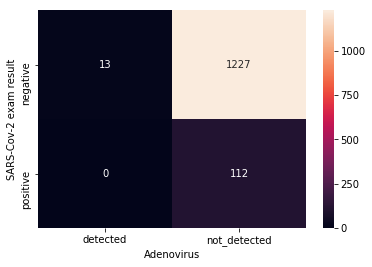

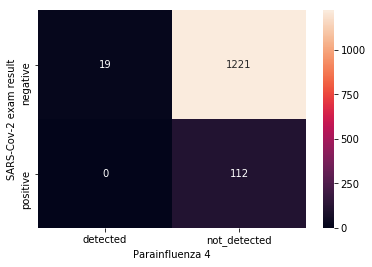

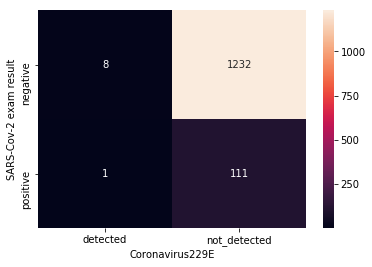

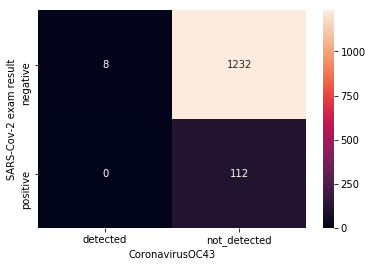

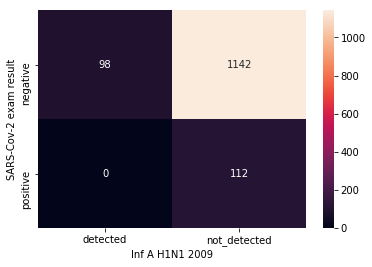

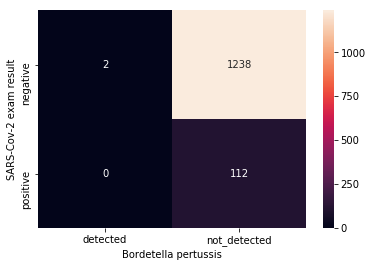

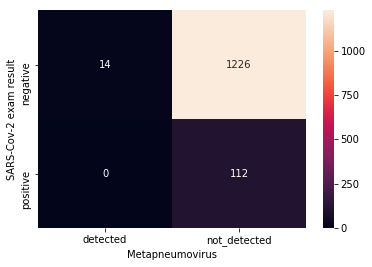

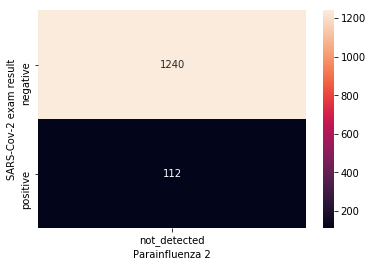

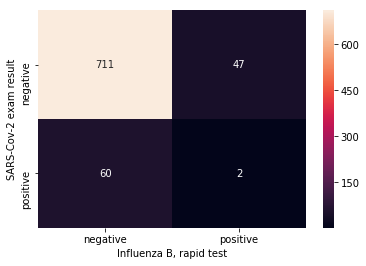

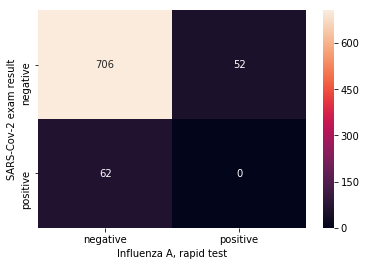

In [100]:
# visualize relationship between categorical features and target
for col in grp2:
    plt.figure()
    sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'],df[col]), annot = True, fmt = 'd')    
    

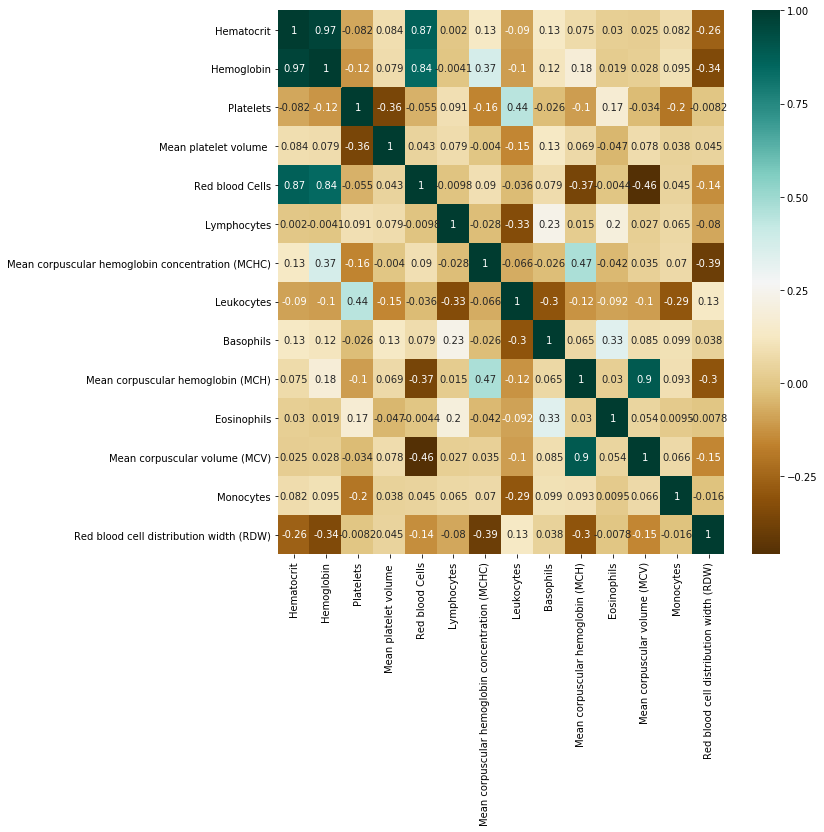

In [117]:
# relationship between different features
plt.figure(figsize=(10,10))
sns.heatmap(df[grp1].corr(),cmap="BrBG",annot=True)

**Some features have a high correlaton (>0.9), which could be used to simplify the model** 

<Figure size 432x288 with 0 Axes>

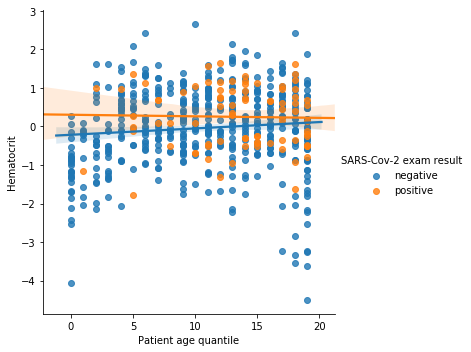

<Figure size 432x288 with 0 Axes>

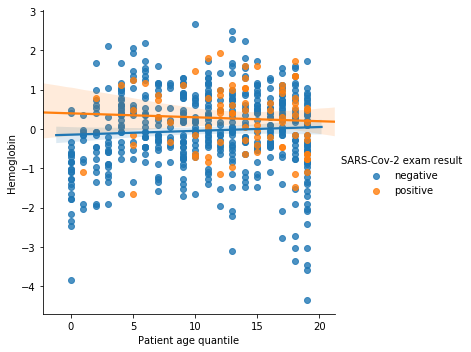

<Figure size 432x288 with 0 Axes>

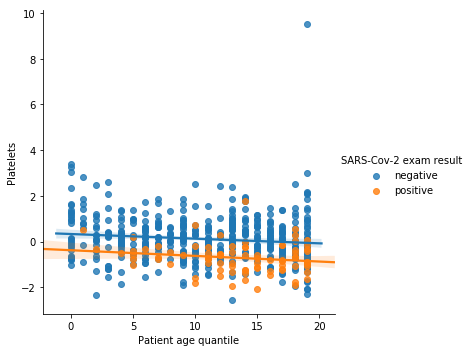

<Figure size 432x288 with 0 Axes>

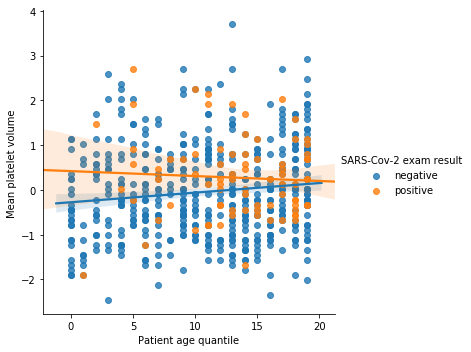

<Figure size 432x288 with 0 Axes>

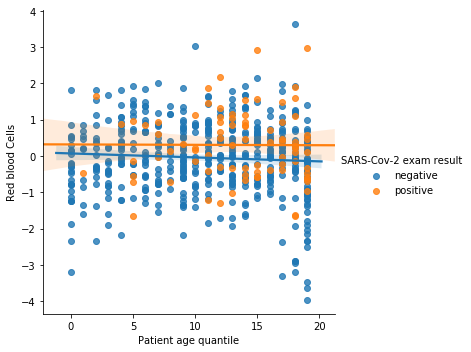

<Figure size 432x288 with 0 Axes>

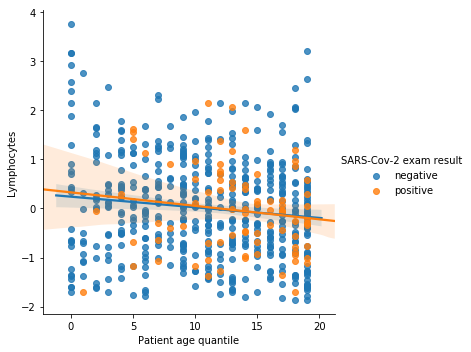

<Figure size 432x288 with 0 Axes>

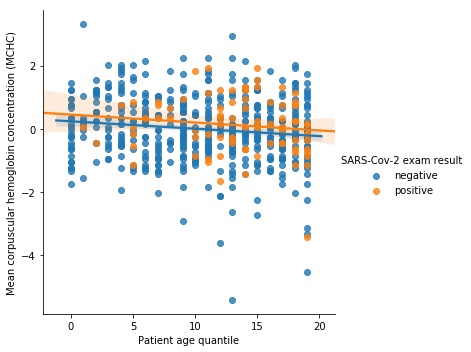

<Figure size 432x288 with 0 Axes>

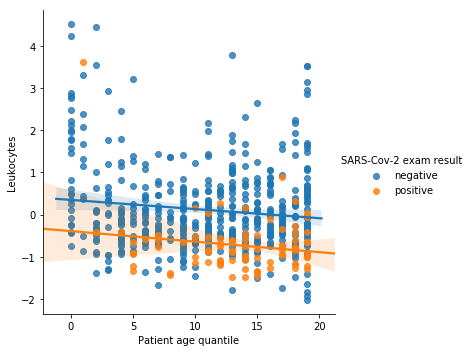

<Figure size 432x288 with 0 Axes>

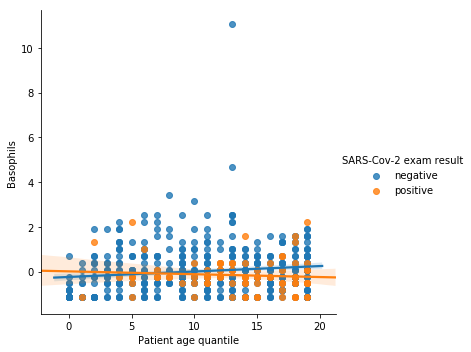

<Figure size 432x288 with 0 Axes>

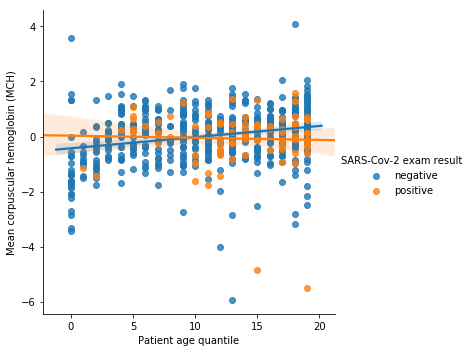

<Figure size 432x288 with 0 Axes>

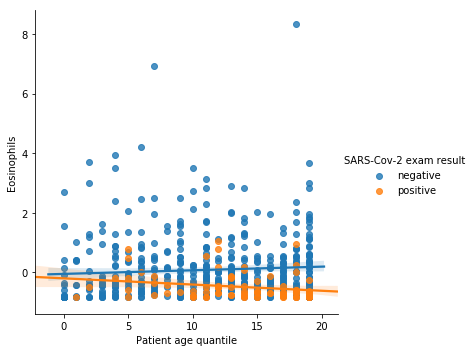

<Figure size 432x288 with 0 Axes>

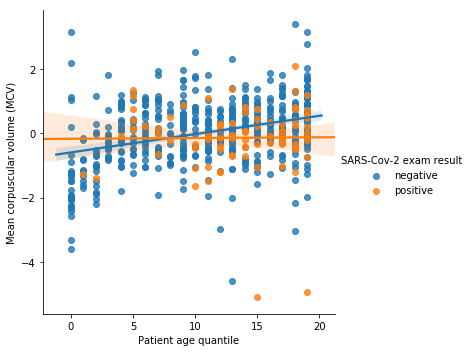

<Figure size 432x288 with 0 Axes>

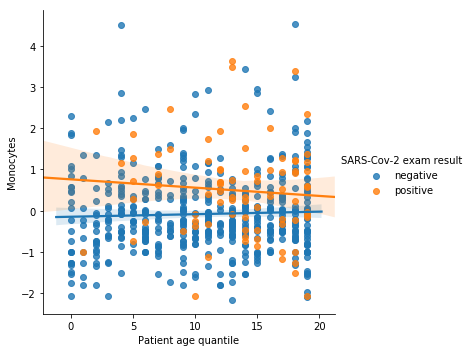

<Figure size 432x288 with 0 Axes>

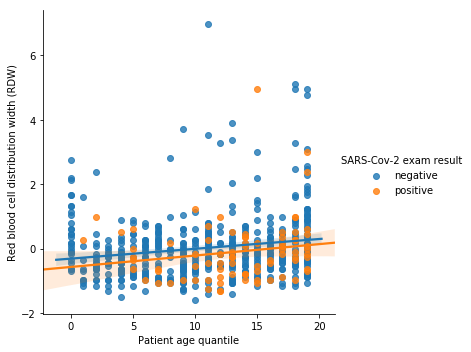

In [118]:
for col in grp1:
    plt.figure()
    sns.lmplot(x='Patient age quantile', y =col, hue = 'SARS-Cov-2 exam result', data = df)

In [119]:
df.corr()['Patient age quantile'].sort_values()

Leukocytes                                              -0.166386
Platelets                                               -0.158683
Lymphocytes                                             -0.125935
Mean corpuscular hemoglobin concentration (MCHC)        -0.124671
Red blood Cells                                         -0.037510
Patient addmited to intensive care unit (1=yes, 0=no)   -0.035772
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.015736
Eosinophils                                              0.022085
Patient addmited to regular ward (1=yes, 0=no)           0.046166
Monocytes                                                0.050962
Hemoglobin                                               0.060320
Hematocrit                                               0.096808
Basophils                                                0.107525
Mean platelet volume                                     0.119449
Red blood cell distribution width (RDW)                  0.166429
Mean corpu

**Weak correlation between 'Patient age quantile' and the other features of grp1**

In [120]:
pd.crosstab(df['Influenza A'], df['Influenza A, rapid test'])

"Influenza A, rapid test",negative,positive
Influenza A,,
detected,2,4
not_detected,245,15


In [121]:
pd.crosstab(df['Influenza B'], df['Influenza B, rapid test'])

"Influenza B, rapid test",negative,positive
Influenza B,,
detected,18,11
not_detected,233,4


**These rapid tests don't seem to be highly reliable**

In [123]:
def hosp(df):
    if df['Patient addmited to regular ward (1=yes, 0=no)'] == 1:
        return 'US' #under surveillance
    if df['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1:
        return 'SIC' #semi Intensive care
    if df['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1:
        return 'IC' # INTENSIVE CARE
    else:
        return 'unknown'


df['status'] = df.apply(hosp, axis= 1 )

ValueError: cannot convert float NaN to integer

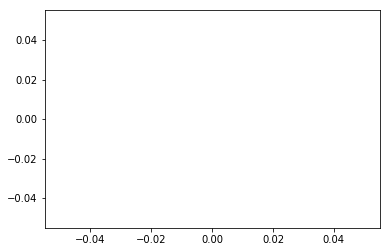

In [129]:
for col in grp1:
    plt.figure()
    for cat in df['status'].unique():
        sns.distplot(df[df['status'] == cat][col], label = cat)
    plt.legent()    
    

In [128]:
df['status'].value_counts()

unknown    5474
US           79
SIC          50
IC           41
Name: status, dtype: int64

 **Pre-processing**

Based on the previous EDA, let's keep the most relevant columns of our dataset for the remainng steps 

In [219]:
dff = df[['Patient age quantile', 'SARS-Cov-2 exam result']+ list(grp1) + list(grp2) ]


In [206]:
dff = dff.drop('Influenza B, rapid test', axis =1)
dff = dff.drop('Influenza A, rapid test', axis =1)
dff.head()

,Patient age quantile,SARS-Cov-2 exam result,...,Metapneumovirus,Parainfluenza 2
0,13,negative,...,NaN,NaN
1,17,negative,...,not_detected,not_detected
2,8,negative,...,NaN,NaN
3,5,negative,...,NaN,NaN
4,15,negative,...,not_detected,not_detected


In [220]:
train,test = train_test_split(dff, test_size = 0.2, random_state =0) 

In [146]:
train['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [147]:
test['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [170]:
# encoding

def encode(dff):
    dict = {'positive': 1,
        'negative':0,
        'detected':1,
        'not_detected':0
       }
    for col in dff.select_dtypes('object'):
        dff[col] = dff[col].map(dict)
    return dff
    

In [151]:
# no more features of type 'object'
dff.dtypes.value_counts()

float64    31
int64       2
dtype: int64

In [191]:
# eliminate NAN
def imputate(dff):
    return dff.dropna(axis = 0)
     

In [214]:
def featureeng(dff):
    dff ['pos']= dff[list(grp2)].sum(axis=1) >= 1
    dff = dff.drop(list(grp2), axis =1)   
    return dff

In [215]:
def preproc(dff):
    dff = encode(dff)
    dff = featureeng(dff)
    dff = imputate(dff)
    x = dff.drop('SARS-Cov-2 exam result', axis = 1)
    y = dff['SARS-Cov-2 exam result']
    return x,y

In [221]:
xtrain, ytrain = preproc(train)

In [222]:
xtest,ytest = preproc(test)

In [200]:
display(train.shape)
display(xtrain.shape)

(4515, 16)

(487, 15)

**LEARNING MODEL**

In [182]:
model = DecisionTreeClassifier (random_state = 0)

In [189]:
def eval(model):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print(confusion_matrix(ytest,ypred))
    print(classification_report(ytest,ypred))
    N, trainscore,valscore = learning_curve(model, xtrain,ytrain,
                                            cv= 4, scoring = 'f1', train_sizes = np.linspace(0.1,1,10))
    plt.figure()
    plt.plot(N, trainscore.mean(axis = 1), label = 'train score')
    plt.plot(N, valscore.mean(axis = 1), label = 'val score')
    plt.legend()

[[87  8]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        95
           1       0.43      0.38      0.40        16

   micro avg       0.84      0.84      0.84       111
   macro avg       0.66      0.65      0.65       111
weighted avg       0.83      0.84      0.83       111



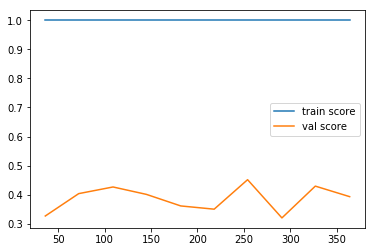

In [201]:
eval(model)

This simple model is overfitted. Let's try feature selection to improve it. 

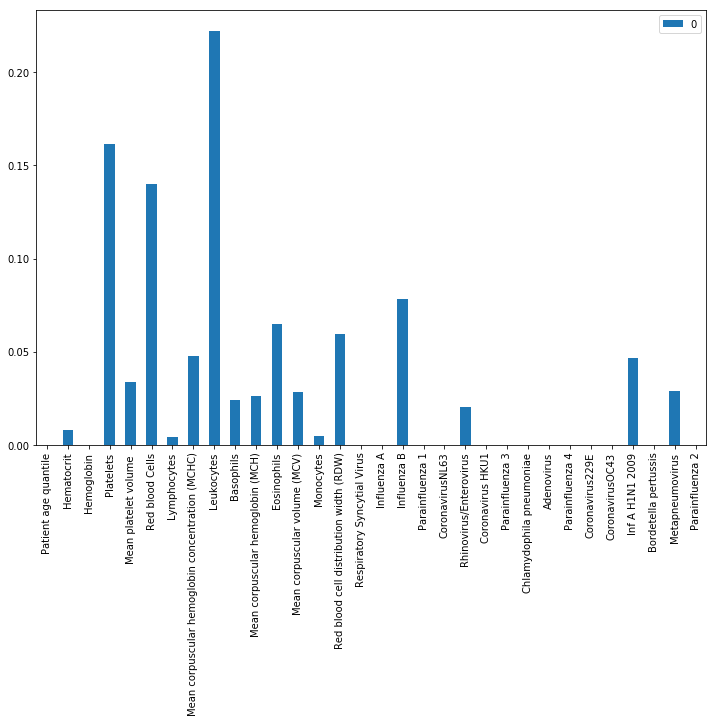

In [194]:
pd.DataFrame(model.feature_importances_, index = xtrain.columns).plot.bar(figsize=(12,8))

**Based on the feature importance results, columns from grp2 have a low score thus we eliminate them**

In [195]:
dff = df[['Patient age quantile', 'SARS-Cov-2 exam result']+ list(grp1)  ]

[[87  8]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        95
           1       0.43      0.38      0.40        16

   micro avg       0.84      0.84      0.84       111
   macro avg       0.66      0.65      0.65       111
weighted avg       0.83      0.84      0.83       111



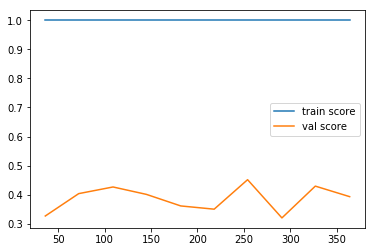

In [202]:
eval(model)

**This doesn't improve the model performance. Let's try a more complex model.** 

In [210]:
model= RandomForestClassifier(random_state = 0)

[[91  4]
 [12  4]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        95
           1       0.50      0.25      0.33        16

   micro avg       0.86      0.86      0.86       111
   macro avg       0.69      0.60      0.63       111
weighted avg       0.83      0.86      0.83       111



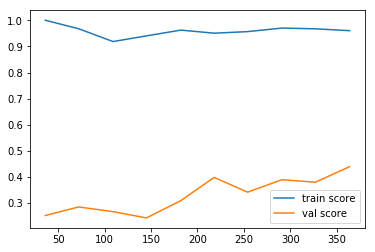

In [224]:
eval(model)

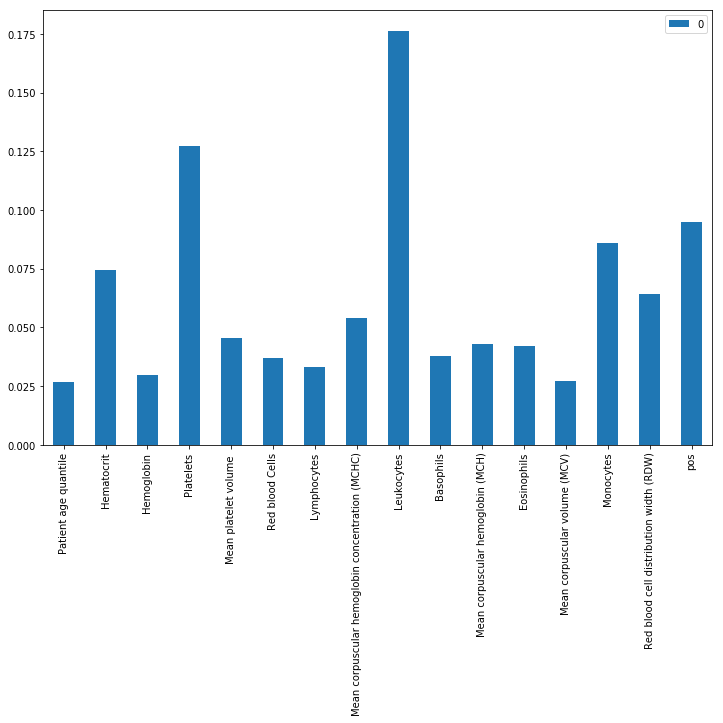

In [225]:
pd.DataFrame(model.feature_importances_, index = xtrain.columns).plot.bar(figsize=(12,8))

[[90  5]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        95
           1       0.55      0.38      0.44        16

   micro avg       0.86      0.86      0.86       111
   macro avg       0.72      0.66      0.68       111
weighted avg       0.85      0.86      0.85       111



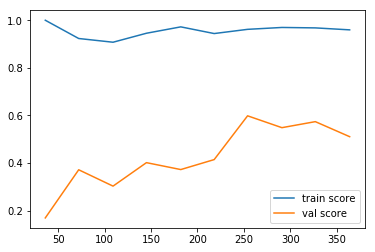

In [234]:
model = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k = 10),
                     RandomForestClassifier(random_state=0))
eval(model)

In [237]:
proc = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k = 10))

In [255]:
RF = make_pipeline(proc,RandomForestClassifier(random_state = 0))
AB = make_pipeline(proc,AdaBoostClassifier(random_state = 0))
SVM = make_pipeline(proc, StandardScaler(),SVC(random_state = 0))
KNN = make_pipeline(proc, StandardScaler(),KNeighborsClassifier())

In [240]:
mdlist = [ RF, AB, SVM, KNN]

[[90  5]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        95
           1       0.55      0.38      0.44        16

   micro avg       0.86      0.86      0.86       111
   macro avg       0.72      0.66      0.68       111
weighted avg       0.85      0.86      0.85       111

[[90  5]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        95
           1       0.55      0.38      0.44        16

   micro avg       0.86      0.86      0.86       111
   macro avg       0.72      0.66      0.68       111
weighted avg       0.85      0.86      0.85       111

[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

   micro avg       0.88      0.88      0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg     

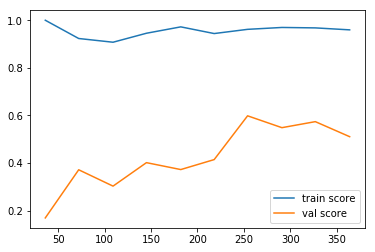

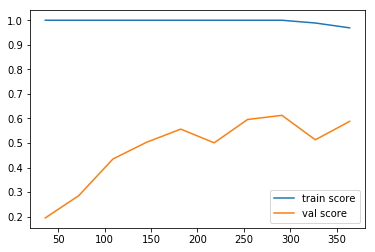

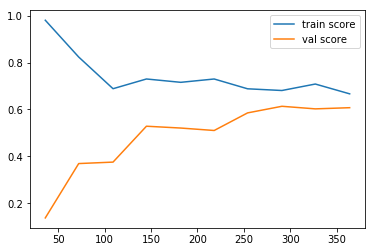

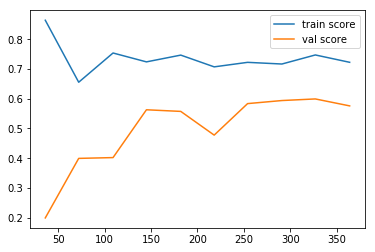

In [241]:
for mdl in mdlist:
    eval(mdl)
     

**SVM and KNN allow to reduce the gap between train and val scores.** 

**AdaBoost allows to increase val score too.**

**SVM offers the smallest gap between train and val scores.**

In [264]:
#Let's try to optimize SVM 

params = {'svc__C': [1,10,100,1000],
          'svc__gamma': [1e-3,1e-4],
          'pipeline__polynomialfeatures__degree':[2,3,4],
          'pipeline__selectkbest__k':range(40,60)
         }
grid = RandomizedSearchCV(SVM,params, scoring = 'recall',cv = 4,n_iter = 40)
grid.fit(xtrain,ytrain)
print(grid.best_params_)
ypred = grid.predict(xtest)
print(classification_report(ytest,ypred))

{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 47, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        95
           1       0.56      0.56      0.56        16

   micro avg       0.87      0.87      0.87       111
   macro avg       0.74      0.74      0.74       111
weighted avg       0.87      0.87      0.87       111



[[88  7]
 [ 7  9]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        95
           1       0.56      0.56      0.56        16

   micro avg       0.87      0.87      0.87       111
   macro avg       0.74      0.74      0.74       111
weighted avg       0.87      0.87      0.87       111



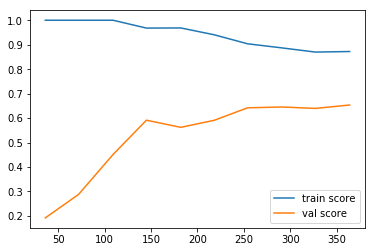

In [265]:
eval(grid.best_estimator_)

In [268]:
precision, recall, threshold = precision_recall_curve(ytest, grid.best_estimator_.decision_function(xtest))

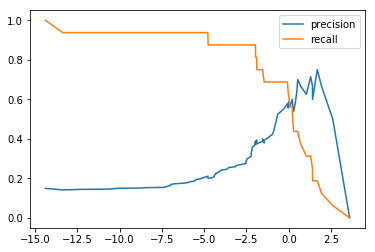

In [269]:
plt.plot(threshold,precision[:-1], label ='precision')
plt.plot(threshold,recall[:-1], label ='recall')
plt.legend()

In [270]:
def covidpred(model,x,threshold=0):
    return model.decision_function(x)> threshold

In [278]:
ypred = covidpred(grid.best_estimator_,xtest, threshold = 0)
f1_score(ytest,ypred)

0.5625

In [292]:
#Let's try to optimize ADABOOST 

params = {'adaboostclassifier__learning_rate': [0.1,1],
          'adaboostclassifier__n_estimators': range(10,50),
          'pipeline__polynomialfeatures__degree':[2,3,4],
          'pipeline__selectkbest__k':range(10,30)
         }
grid = RandomizedSearchCV(AB,params, scoring = 'recall',cv = 4,n_iter = 40)
grid.fit(xtrain,ytrain)
print(grid.best_params_)
ypred = grid.predict(xtest)
print(classification_report(ytest,ypred))

{'pipeline__polynomialfeatures__degree': 3, 'adaboostclassifier__n_estimators': 44, 'adaboostclassifier__learning_rate': 1, 'pipeline__selectkbest__k': 17}
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        95
           1       0.57      0.50      0.53        16

   micro avg       0.87      0.87      0.87       111
   macro avg       0.74      0.72      0.73       111
weighted avg       0.87      0.87      0.87       111



[[89  6]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        95
           1       0.57      0.50      0.53        16

   micro avg       0.87      0.87      0.87       111
   macro avg       0.74      0.72      0.73       111
weighted avg       0.87      0.87      0.87       111



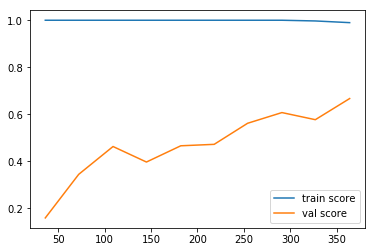

In [294]:
eval(grid.best_estimator_)

In [293]:
ypred = covidpred(grid.best_estimator_,xtest, threshold = 0)
f1_score(ytest,ypred)

0.5333333333333333

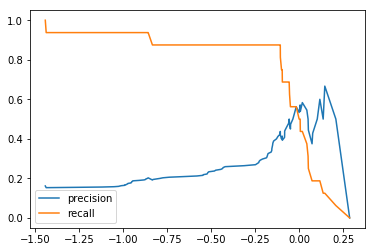

In [295]:
precision, recall, threshold = precision_recall_curve(ytest, grid.best_estimator_.decision_function(xtest))
plt.plot(threshold,precision[:-1], label ='precision')
plt.plot(threshold,recall[:-1], label ='recall')
plt.legend()

In [298]:
ypred = covidpred(grid.best_estimator_,xtest, threshold = 0)
f1_score(ytest,ypred)

0.5333333333333333

**Conclusion:**
    
**SVM offers a higher F1 score for our classification problem compared to the other investigated models.**
    
**SVM is usually suitable for classification problems with small to medium datasets.**  